In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [5]:
print(train_df.info())
print(train_df.describe())
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

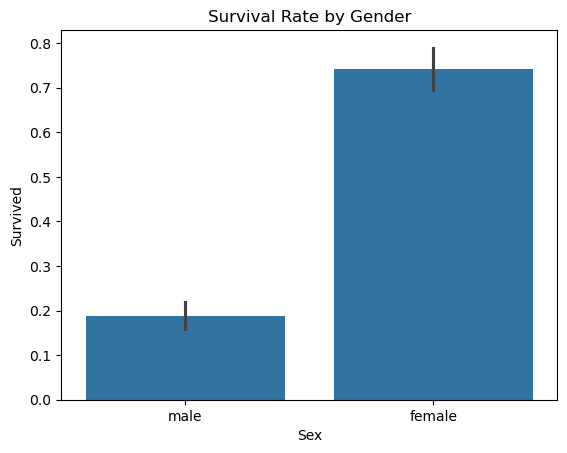

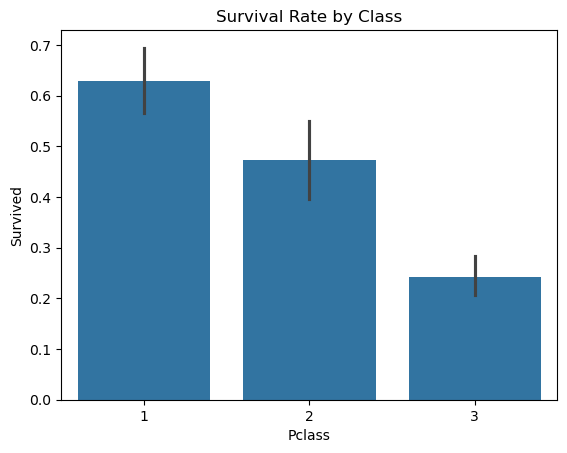

In [7]:
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title("Survival Rate by Gender")
plt.show()

sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.title("Survival Rate by Class")
plt.show()

In [9]:
combine = [train_df, test_df]
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})
for dataset in combine:
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())


In [11]:
drop_columns = ['Ticket', 'Cabin', 'Name', 'PassengerId']
train_df = train_df.drop(drop_columns, axis=1)
test_df_passenger_ids = test_df['PassengerId']
test_df = test_df.drop(drop_columns, axis=1)

In [13]:
X = train_df.drop("Survived", axis=1)
y = train_df["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")

Validation Accuracy: 0.8268156424581006


In [15]:
final_pred = model.predict(test_df)

submission = pd.DataFrame({
    "PassengerId": test_df_passenger_ids,
    "Survived": final_pred
})

submission.to_csv("titanic_submission.csv", index=False)

In [23]:
train_df1 = pd.read_csv("train.csv")
test_df1 = pd.read_csv("test.csv")
full_data = pd.concat([train_df1, test_df1], sort=False)

full_data['Title'] = full_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
full_data['Title'] = full_data['Title'].replace(['Lady', 'Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
full_data['Title'] = full_data['Title'].replace('Mlle', 'Miss')
full_data['Title'] = full_data['Title'].replace('Ms', 'Miss')
full_data['Title'] = full_data['Title'].replace('Mme', 'Mrs')

title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
full_data['Title'] = full_data['Title'].map(title_mapping).fillna(0)

full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1
full_data['IsAlone'] = 1  
full_data.loc[full_data['FamilySize'] > 1, 'IsAlone'] = 0


In [25]:
full_data['Embarked'] = full_data['Embarked'].fillna('S')
full_data['Embarked'] = full_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

full_data['Fare'] = full_data['Fare'].fillna(full_data['Fare'].median())

full_data['Age'] = full_data['Age'].fillna(full_data['Age'].median())
full_data['Sex'] = full_data['Sex'].map({'male': 0, 'female': 1}).astype(int)

In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train_X = full_data.loc[full_data['Survived'].notnull()].drop(['Survived', 'PassengerId'], axis=1)
train_y = full_data.loc[full_data['Survived'].notnull()]['Survived'].astype(int)
test_X = full_data.loc[full_data['Survived'].isnull()].drop(['Survived', 'PassengerId'], axis=1)
test_ids = full_data.loc[full_data['Survived'].isnull()]['PassengerId']

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        print(f"Encoding column: {col}")
        le = LabelEncoder()
        all_vals = pd.concat([X_train[col], X_val[col], test_X[col]])
        le.fit(all_vals.astype(str))
        X_train[col] = le.transform(X_train[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))
        test_X[col] = le.transform(test_X[col].astype(str))

xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

val_preds = xgb_model.predict(X_val)
print(f"Validation Accuracy (XGBoost): {accuracy_score(y_val, val_preds)}")

Encoding column: Name
Encoding column: Ticket
Encoding column: Cabin
Validation Accuracy (XGBoost): 0.8435754189944135


C:\Users\arjun\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:03:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [39]:
final_preds = xgb_model.predict(test_X)

submission = pd.DataFrame({
    "PassengerId": test_ids.astype(int),   
    "Survived": final_preds.astype(int)    
})

submission.to_csv("titanic_submission.csv", index=False)
